# Cohort Creation

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
bd=pd.read_excel('/gdrive/MyDrive/CE/BDEX Export from Qlik - May 20, 2021.xlsx')

In [3]:
bd['udm_user_found']=bd['UDM Consumer User ID'].map({'No Match Found': False}).fillna(True)

In [4]:
bd.Vendor.value_counts()

DI    182405
Name: Vendor, dtype: int64

In [5]:
met_dict= {'email_address': 'count', 'udm_user_found': 'sum'}
bf= bd.loc[bd.Vendor=='DI'].groupby('Client Account AS400 ID').agg(met_dict).reset_index()
bf.columns=['as400id', 'emails', 'users_found']
bf['opportunity_size']= bf.emails- bf.users_found
bf['bdex']= 'Y'

In [6]:
len(bf.as400id.unique())

2215

In [7]:
mf= pd.read_csv('/gdrive/MyDrive/CE/mcount0526.csv')

In [8]:
len(mf.as400id.unique())

2215

In [9]:
mf.columns

Index(['as400id', 'PROPERTYCLASS', 'transacted_machine_cnt', 'Industry',
       'IndustrySubType'],
      dtype='object')

In [10]:
bf= bf.loc[bf.opportunity_size > 9]

In [11]:
bf.shape

(1826, 5)

In [12]:
bf.merge(mf, how='inner', on= 'as400id').shape

(1826, 9)

In [13]:
df=pd.read_csv('/gdrive/MyDrive/CE/uupm.csv')
df.columns= ['as400id', 'payment_type', 'weeknum', 'uniq_transactors', 'amt']

In [14]:
ditch=[]
for a in df.as400id:
  try:
    int(a)
  except:
    ditch.append(a)
ditch.append('-303934')
ditch.append('0')
ditch.append('000000000')
ditch.append('999999999')
ditch = set(ditch)

In [15]:
ditch

{'\x03313659',
 '\x12314882',
 '\x13314882',
 '\x14201731',
 '\x14313904',
 '\x15108932',
 ',303934',
 '-303934',
 '0',
 '000000000',
 '11076 20210125000700',
 '14415  2021031200082',
 '1597     20210303001',
 '201522 2021012401104',
 '2101878 202103210005',
 '2101878 202103210029',
 '2101878 202103270005',
 '2120047  20210220010',
 '2120047 202103020107',
 '2120047 202103060101',
 '2120047 202103260108',
 '2902     20210321000',
 '2902    202102080003',
 '2902    202103080003',
 '2906  20210326000639',
 '2960  20210319000418',
 '3009     20210314010',
 '3010     20210330010',
 '3010    202101100102',
 '3792     20210320020',
 '3792    202103180109',
 '3792    202103210105',
 '3792    202103220104',
 '3792    202103280002',
 '4\x1413904',
 '4(03934',
 '4,03934',
 '40874   202101200005',
 '4225287 202102221302',
 '43\x147258',
 '43\x158135',
 '43,3934',
 '43112\x138',
 '43112\x148',
 '43112 8',
 '43278\x146',
 '4328?ÿÿÿÿÿ000030',
 '5\x14131',
 '503354   20210321000',
 '59131;',
 '6\x152

In [16]:
df1=df.loc[~df.as400id.isin(ditch)]

In [17]:
len(df1.as400id.unique())

13803

In [18]:
df11=df1.loc[df.weeknum <= 16].groupby('as400id')['uniq_transactors', 'amt'].sum().divide(16)
df11.columns=['UniqTxntrAll', 'AmtAll']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [19]:
df12=df1.loc[(df.weeknum <= 16) & (df.payment_type=='App')].groupby('as400id')['uniq_transactors', 'amt'].sum().divide(16)
df12.columns=['UniqTxntrApp', 'AmtApp']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [20]:
df2=pd.concat([df11,df12], axis=1, join='outer').fillna(0).reset_index()
df2.columns= ['as400id', 'UniqTxntrAll', 'AmtAll', 'UniqTxntrApp', 'AmtApp']

In [21]:
import numpy as np
df2['UnitVendAlldollar']= df2.AmtAll/(np.where(df2.UniqTxntrAll==0, 1, df2.UniqTxntrAll)*100.0)
df2['UnitVendAppdollar']= df2.AmtApp/(np.where(df2.UniqTxntrApp==0, 1, df2.UniqTxntrApp)*100.0)

In [22]:
bf.dtypes

as400id              int64
emails               int64
users_found          int64
opportunity_size     int64
bdex                object
dtype: object

In [23]:
bf.as400id= bf.as400id.astype(str)

In [24]:
mf.dtypes

as400id                    int64
PROPERTYCLASS             object
transacted_machine_cnt     int64
Industry                  object
IndustrySubType           object
dtype: object

In [25]:
mf.as400id= mf.as400id.astype(str)

In [26]:
df2.dtypes

as400id               object
UniqTxntrAll         float64
AmtAll               float64
UniqTxntrApp         float64
AmtApp               float64
UnitVendAlldollar    float64
UnitVendAppdollar    float64
dtype: object

In [27]:
df3=bf.merge(mf, how='inner', on= 'as400id').merge(df2, how='inner', on='as400id')

In [28]:
len(df3.as400id)

1775

In [29]:
df3.PROPERTYCLASS.value_counts()

Class C    1775
Name: PROPERTYCLASS, dtype: int64

In [30]:
df3.opportunity_size.sum()

170717

In [31]:
df3.to_csv('/content/cohort1.csv')

In [32]:
df3.opportunity_size.sum()

170717

In [33]:
df3.head()

,as400id,emails,users_found,opportunity_size,bdex,PROPERTYCLASS,transacted_machine_cnt,Industry,IndustrySubType,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar
0,614,22,1,21,Y,Class C,4,Multi-Housing,Apartments,5.0625,4800.0000,1.6250,2485.9375,9.481481,15.298077
1,5514,78,2,76,Y,Class C,4,Multi-Housing,Apartments,16.4375,15526.5625,3.6875,3292.1875,9.445817,8.927966
2,6618,27,1,26,Y,Class C,2,Multi-Housing,Apartments,1.4375,990.6250,1.4375,946.8750,6.891304,6.586957
3,7181,12,1,11,Y,Class C,2,Multi-Housing,Apartments,3.1875,2623.3750,1.6250,1470.5625,8.230196,9.049615
4,8074,200,5,195,Y,Class C,13,Multi-Housing,Apartments,11.6250,8310.9375,0.1250,87.5000,7.149194,7.000000


In [34]:
df3['AlltxntrperMc']= df3.UniqTxntrAll/df3.transacted_machine_cnt

In [35]:
df3.AlltxntrperMc.describe()

count    1775.000000
mean        1.437148
std         1.094475
min         0.000000
25%         0.617188
50%         1.250000
75%         1.984375
max         7.505208
Name: AlltxntrperMc, dtype: float64

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
AlltxntrperMc,1775,1.43715,1.09447,0,0.617188,1.25,1.98438,7.50521


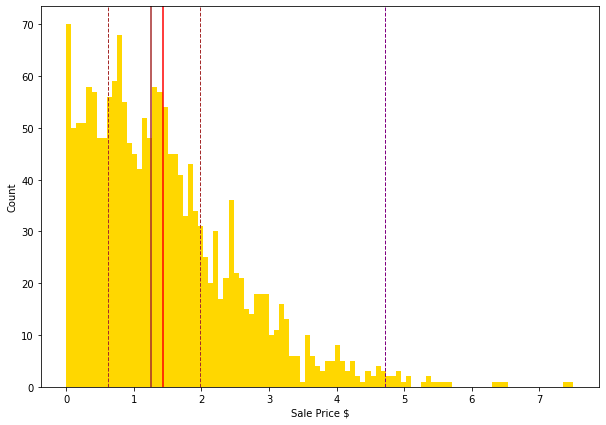

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(df3.AlltxntrperMc, color='gold', bins=100,log=False, histtype='bar')
# plt.hist(df3.AlltxntrperMc.sample(frac=.4, replace=False, random_state=42, axis=0), color='orange', bins=100,log=False, histtype='bar')
plt.xlabel('Sale Price $')
plt.ylabel('Count')
plt.axvline(df3.AlltxntrperMc.mean(), color='red', linestyle='solid', linewidth=1.5)
plt.axvline(df3.AlltxntrperMc.median(), color='brown', linestyle='solid', linewidth=1.5)
plt.axvline(df3.AlltxntrperMc.describe().loc['25%'], color='brown', linestyle='dashed', linewidth=1)
plt.axvline(df3.AlltxntrperMc.describe().loc['75%'], color='brown', linestyle='dashed', linewidth=1)
plt.axvline(df3.AlltxntrperMc.describe().loc['mean']+ 3*df3.AlltxntrperMc.describe().loc['std'], color='purple', linestyle='dashed', linewidth=1)
# plt.axvline(df3.AlltxntrperMc.describe().loc['mean']- 3*df3.AlltxntrperMc.describe().loc['std'], color='purple', linestyle='dashed', linewidth=1)
# # plt.axvline(df3.AlltxntrperMc.describe().loc['mean']- 3*df3.AlltxntrperMc.loc['std'], color='purple', linestyle='dashed', linewidth=1)
# plt.show()
df3.AlltxntrperMc.describe().reset_index().T

In [37]:
def add_campaignflag(df, col='AlltxntrperMc', splits=[.4,.4,.2]):
  np.random.seed(42)
  df['dec']= pd.qcut(df[col], 10, labels=np.arange(10, 0, -1))
  dfs=[]
  for i,d in enumerate(list(df3.dec.unique())):
    df1= df.loc[df.dec==d]
    ixs= np.arange(df1.shape[0])
    np.random.shuffle(ixs)
    # print(i,d,len(ixs))
    df1['camp_flag']= None
    start=0
    for i,s in enumerate(splits):
      stop= start+int(round(s*len(df1),0))
      df1.loc[:,'camp_flag'].iloc[start:stop]= 'split_'+str(i)
      start = stop
      # print(i,d,stop,start,df1.camp_flag.value_counts())
    # print(d,df1.camp_flag.value_counts())
    dfs.append(df1)
  df4= pd.concat(dfs, axis=0)
  return(df4)

In [38]:
df4=add_campaignflag(df3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

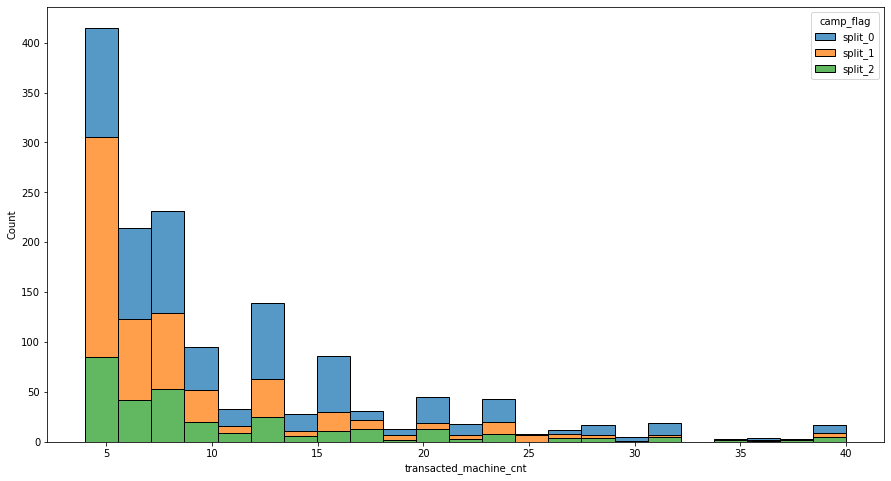

In [39]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df4.loc[df4.transacted_machine_cnt.between(4,40)], x= 'transacted_machine_cnt', ax=ax, hue='camp_flag', multiple="stack")

In [40]:
df4.camp_flag= df4.camp_flag.map({'split_0': 'cohort1', 'split_1': 'cohort2', 'split_2':'control'})

In [41]:
df4.camp_flag.value_counts().sum()

1771

In [42]:
df4.groupby('dec')['AlltxntrperMc'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
dec,,,,,,,,
10,181.0,0.108613,0.075812,0.000000,0.031250,0.120192,0.175000,0.234375
9,174.0,0.364562,0.067134,0.238281,0.308239,0.367188,0.421875,0.471154
8,178.0,0.611361,0.073056,0.473214,0.546875,0.617188,0.671875,0.729167
7,177.0,0.840107,0.065230,0.730519,0.781250,0.833333,0.895833,0.965909
6,182.0,1.112974,0.083810,0.968750,1.039062,1.125000,1.179688,1.250000
5,182.0,1.379680,0.072799,1.255208,1.312500,1.375000,1.437500,1.500000
4,171.0,1.648282,0.088503,1.505208,1.570089,1.640625,1.721094,1.812500
3,176.0,2.011575,0.131029,1.818750,1.894531,1.984976,2.135937,2.250000
2,176.0,2.552834,0.176461,2.253472,2.421875,2.528556,2.700781,2.875000


In [43]:
df4.columns

Index(['as400id', 'emails', 'users_found', 'opportunity_size', 'bdex',
       'PROPERTYCLASS', 'transacted_machine_cnt', 'Industry',
       'IndustrySubType', 'UniqTxntrAll', 'AmtAll', 'UniqTxntrApp', 'AmtApp',
       'UnitVendAlldollar', 'UnitVendAppdollar', 'AlltxntrperMc', 'dec',
       'camp_flag'],
      dtype='object')

In [44]:
df4.groupby(['camp_flag'])['AlltxntrperMc'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
camp_flag,,,,,,,,
cohort1,709.0,1.433860,1.094008,0.0,0.600000,1.240385,1.943750,6.406250
cohort2,709.0,1.422326,1.048307,0.0,0.625000,1.234375,2.015625,5.649038
control,353.0,1.470774,1.186578,0.0,0.626953,1.250000,2.000000,7.505208


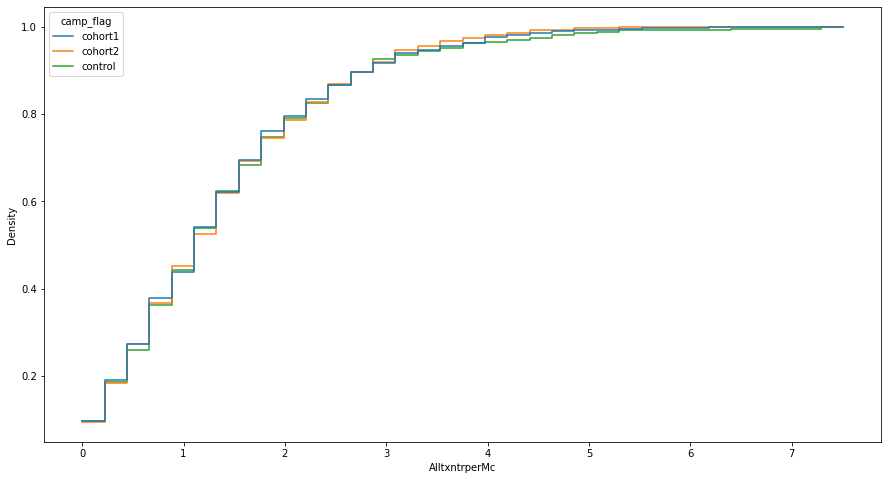

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(
    data=df4, x="AlltxntrperMc", hue="camp_flag",
    hue_order=["cohort1", "cohort2", "control"],
    log_scale=False, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,ax=ax
)

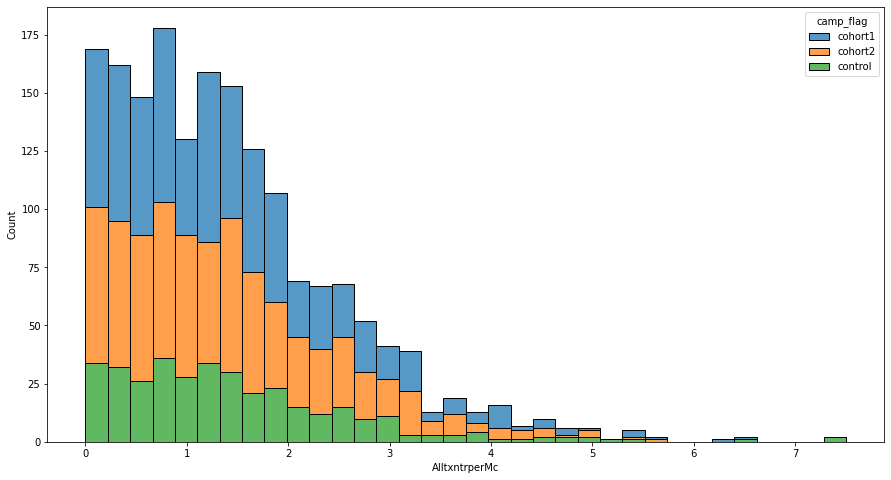

In [46]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df4, x="AlltxntrperMc", hue="camp_flag", multiple="stack", ax=ax)

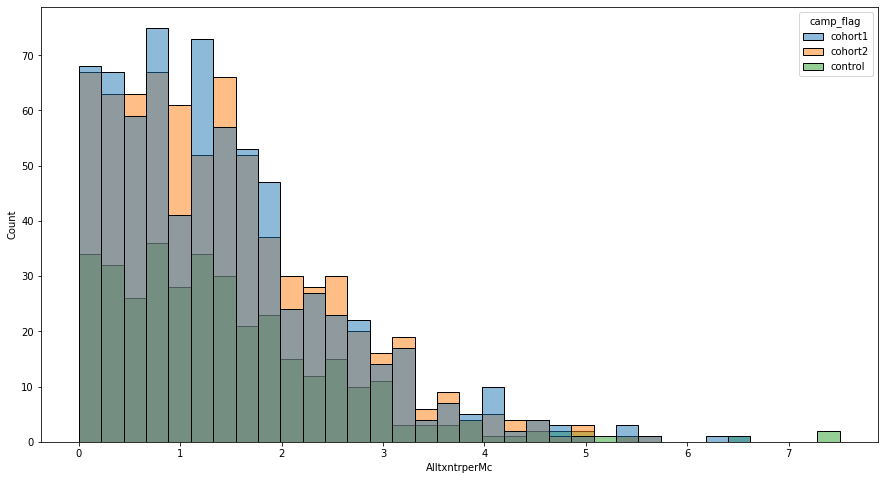

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df4, x="AlltxntrperMc", hue="camp_flag", multiple="layer",ax=ax)

In [48]:
df4.head()

,as400id,emails,users_found,opportunity_size,bdex,PROPERTYCLASS,transacted_machine_cnt,Industry,IndustrySubType,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar,AlltxntrperMc,dec,camp_flag
0,614,22,1,21,Y,Class C,4,Multi-Housing,Apartments,5.0625,4800.0000,1.6250,2485.9375,9.481481,15.298077,1.265625,5,cohort1
23,30267,13,1,12,Y,Class C,57,Multi-Housing,Apartments,76.8750,77957.8125,68.0625,71612.5000,10.140854,10.521579,1.348684,5,cohort1
25,30347,29,1,28,Y,Class C,48,Multi-Housing,Apartments,65.5625,59122.1875,27.8125,26592.1875,9.017684,9.561236,1.365885,5,cohort1
31,30809,85,7,78,Y,Class C,76,Multi-Housing,Apartments,105.0625,98000.6250,89.8750,85183.4375,9.327841,9.477990,1.382401,5,cohort1
34,31946,18,0,18,Y,Class C,8,Multi-Housing,Apartments,11.0000,8442.1875,6.8125,6201.5625,7.674716,9.103211,1.375000,5,cohort1


In [49]:
met_dict1= {'opportunity_size': 'sum','as400id': 'nunique', 'UniqTxntrAll': 'sum', 'transacted_machine_cnt':'sum','AlltxntrperMc': 'std'}

In [50]:
df5=df4.groupby('camp_flag').agg(met_dict1)
df5['AlltxntrperMcMean']= df5.UniqTxntrAll/ df5.transacted_machine_cnt

In [51]:
df5

,opportunity_size,as400id,UniqTxntrAll,transacted_machine_cnt,AlltxntrperMc,AlltxntrperMcMean
camp_flag,,,,,,
cohort1,101996,709,15642.5000,9897,1.094008,1.580529
cohort2,42007,709,9228.3125,6227,1.048307,1.481984
control,26606,353,6815.5000,4693,1.186578,1.452269


In [55]:
tcats=['cohort1', 'cohort2']
tcon= 'control'
A_size= df5.loc[tcon, 'as400id']
A_Mean= df5.loc[tcon, 'AlltxntrperMcMean']
A_var= df5.loc[tcon,'AlltxntrperMc']**2

In [57]:
# from statsmodels.stats.power import TTestPower
from statsmodels.stats.power import TTestIndPower
alpha=0.05
result=[]
for mean_incr in [.01,.05,.075, 0.1, .125, .15, .2]:
  for t in tcats:
    B_size= df5.loc[t, 'as400id']
    B_Mean= df5.loc[t, 'AlltxntrperMcMean']
    B_NewMean= B_Mean*(1+mean_incr)
    B_machines= df5.loc[t, 'transacted_machine_cnt']
    IncrVend= mean_incr*B_Mean*df5.loc[t,'transacted_machine_cnt']
    ConvReq= IncrVend/df5.loc[t,'opportunity_size']
    B_var= df5.loc[t,'AlltxntrperMc']**2
    s= np.sqrt(((A_size-1)*A_var+(B_size-1)*B_var)/(A_size+B_size-2))
    d= abs((B_NewMean- A_Mean)/s)
    p_analysis = TTestIndPower()
    power= p_analysis.solve_power(effect_size=d, nobs1=B_size, alpha=alpha, ratio=B_size/A_size, alternative= 'two-sided')
    print(t,B_NewMean, A_Mean, s, d,power)
    print('____________________________________________________________________________________________________')
    result.append([mean_incr,t,B_Mean,B_NewMean,B_machines,d, IncrVend,ConvReq, power])

cohort1 1.5963347479034051 1.4522693373108886 1.1255926435740236 0.12799071796975742 0.7948546681017115
____________________________________________________________________________________________________
cohort2 1.4968035370162198 1.4522693373108886 1.0961591667970623 0.04062749375663989 0.14309195760328247
____________________________________________________________________________________________________
cohort1 1.6595559260381936 1.4522693373108886 1.1255926435740236 0.18415773229391488 0.9795632392597083
____________________________________________________________________________________________________
cohort2 1.5560828850168622 1.4522693373108886 1.0961591667970623 0.09470663645436919 0.539685645979119
____________________________________________________________________________________________________
cohort1 1.699069162372436 1.4522693373108886 1.1255926435740236 0.2192621162465131 0.9975090705438767
______________________________________________________________________________

In [58]:
df6=pd.DataFrame.from_records(result)
df6.columns=['Delta%- Mean Value', 'Campaign Cohort', 'Original Mean','Increased Mean', '# Machines', 'Effct Size', 'Incremental Vends', 'Required Conversion%', 'power']

In [ ]:
df6

,Delta%- Mean Value,Campaign Cohort,Original Mean,Increased Mean,# Machines,Effct Size,Incremental Vends,Required Conversion%,power
0,0.010,cohort1,1.619989,1.636189,8270,0.127957,133.973125,0.001727,0.793532
1,0.010,cohort2,1.437921,1.452301,7416,0.038871,106.636250,0.001810,0.134768
2,0.050,cohort1,1.619989,1.700989,8270,0.187092,669.865625,0.008635,0.982263
3,0.050,cohort2,1.437921,1.509817,7416,0.012320,533.181250,0.009048,0.058239
4,0.075,cohort1,1.619989,1.741489,8270,0.224052,1004.798438,0.012953,0.998167
5,0.075,cohort2,1.437921,1.545765,7416,0.044314,799.771875,0.013572,0.160965
6,0.100,cohort1,1.619989,1.781988,8270,0.261011,1339.731250,0.017271,0.999896
7,0.100,cohort2,1.437921,1.581714,7416,0.076309,1066.362500,0.018096,0.381151
8,0.125,cohort1,1.619989,1.822488,8270,0.297971,1674.664062,0.021588,1.000000
9,0.125,cohort2,1.437921,1.617662,7416,0.108304,1332.953125,0.022620,0.652456


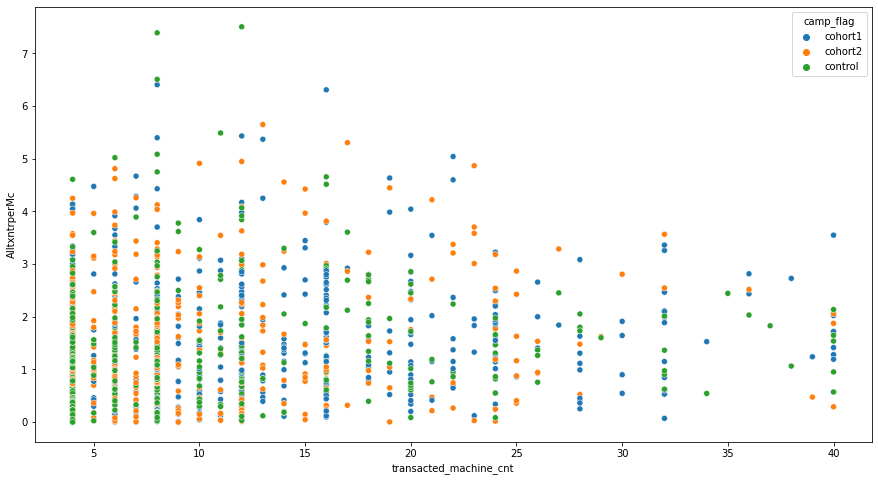

In [61]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=df4.loc[df4.transacted_machine_cnt.between(4,40)], x='transacted_machine_cnt',y='AlltxntrperMc', hue='camp_flag')

# DFORE-83

As a CE Manager, I need to know the baseline number for new consumer completing first vends as a daily average over the 16 weeks prior to the Campaign for Tests 1 (Facebook - New Customer Acquisition) and 2 (email - New Customer Acquisition) beginning 6/1/2021

In [65]:
fb=df4.loc[df4.camp_flag=='cohort1', 'as400id'].tolist()

In [66]:
em= df4.loc[df4.camp_flag=='cohort2', 'as400id'].tolist()

In [67]:
cntrl=df4.loc[df4.camp_flag=='control', 'as400id'].tolist()

In [70]:
print(fb)

['614', '30267', '30347', '30809', '31946', '32398', '38197', '38598', '38857', '38950', '40166', '41947', '42118', '44211', '51060', '51761', '55611', '55780', '57475', '64078', '66878', '66896', '68676', '69671', '69687', '69689', '200860', '201085', '220092', '220570', '400150', '400245', '400670', '420562', '503010', '600186', '600274', '620904', '801194', '802584', '820334', '902097', '920182', '920187', '920830', '1210028', '1220083', '1520417', '1700225', '1700301', '1900058', '1903964', '1920478', '2021711', '2021995', '2022225', '2022301', '2022607', '2500605', '2501064', '2520041', '2520466', '2520849', '2620108', '2620130', '2710890', '2801029', '3001508', '3007891', '3007907', '3020801', '3022890', '4002858', '5514', '9880', '14516', '17414', '32137', '35885', '36836', '39155', '39289', '39568', '42254', '42377', '53889', '57451', '58802', '59070', '60923', '65469', '65559', '85589', '85834', '202324', '220701', '400217', '400824', '420031', '420038', '420459', '420495', '4

In [71]:
print(cntrl)

['4473241', '4473953', '4474016', '4474118', '4475025', '4475843', '4475898', '5517236', '5517630', '5517645', '5518029', '6220266', '6221462', '6222059', '6321668', '6822363', '6875131', '7000379', '7001069', '7200114', '7202607', '7203903', '7206243', '7207403', '7211673', '7230400', '7301046', '7301331', '7403355', '7407647', '7407650', '7407669', '7407690', '7410343', '7600648', '7601349', '5404121', '6220721', '6221031', '6221207', '6221881', '6222430', '6321048', '6520168', '6608188', '6808150', '6822445', '6822545', '6826693', '6875267', '6876511', '7000797', '7001046', '7002521', '7200326', '7200391', '7202776', '7203824', '7204575', '7205311', '7207131', '7211393', '7211686', '7230048', '7307734', '7308017', '7312555', '7317978', '7317987', '7319648', '7319662', '7404510', '6220930', '6221234', '6222298', '6321059', '6321287', '6321681', '6321747', '6608346', '6828182', '7000962', '7001501', '7004057', '7004346', '7200384', '7200626', '7200893', '7201336', '7202356', '7202510'

In [ ]:
%cp /content/email_co1.csv '/gdrive/MyDrive/CE/email_co10525.csv'
%cp /content/email_co2.csv '/gdrive/MyDrive/CE/email_co220525.csv'
%cp /content/email_control.csv '/gdrive/MyDrive/CE/email_cntrl0525.csv'

In [ ]:
%cd '/content'

/content


In [ ]:
%ls '/content/'

cohort1.csv  email_co1.csv  email_co2.csv  email_control.csv  sample_data/


In [ ]:
df4.loc[df4.camp_flag=='cohort1'].as400id.tolist()

## Other Stuff

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return(df_train, df_val, df_test)

In [ ]:
import pandas as pd

positions = {"least": 0.277220, "left": 0.250000, "right": 0.250000, "left-center": 0.141244, "right-center": 0.081536}
data = [['title-{}-{}'.format(i, position), position] for i in range(1000) for position in positions.keys()]
frame = pd.DataFrame(data=data, columns=['title', 'position'])
print(frame.shape)


def sample(obj, replace=False, total=1000):
    return obj.sample(n=int(positions[obj.name] * total), replace=replace)

result = frame.groupby('position', as_index=False).apply(sample).reset_index(drop=True)
print(result.groupby('position').agg('count'))

In [ ]:
bd['UDM Consumer User ID'].value_counts()

No Match Found    219536
379430                 1
174187                 1
1339778                1
1130853                1
                   ...  
794732                 1
782415                 1
15094                  1
330472                 1
1067340                1
Name: UDM Consumer User ID, Length: 7177, dtype: int64

In [ ]:
len(bd.loc[bd['Client Account AS400 ID'].isin(df4.loc[df4.camp_flag=='control'].as400id.tolist())]['email_address'])

33731

In [ ]:
bd.loc[bd['Client Account AS400 ID'].isin(df4.loc[df4.camp_flag=='cohort1'].as400id.tolist())]['email_address'].to_csv('/content/email_co1.csv')

In [ ]:
bd.loc[bd['Client Account AS400 ID'].isin(df4.loc[df4.camp_flag=='cohort2'].as400id.tolist())]['email_address'].to_csv('/content/email_co2.csv')

In [ ]:
bd.loc[bd['Client Account AS400 ID'].isin(df4.loc[df4.camp_flag=='control'].as400id.tolist())]['email_address'].to_csv('/content/email_control.csv')